In [2]:
## analyse the data
import mne
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn import preprocessing
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

**From the paper**  
'1023': 1 (Rejected trial),   
 '1072': 2 (Eye movements),  
 '276':  3 (eyes open)),  
 '277':  4 (eyes closed),   
 '32766':5 (Start of a new run),  
 '768':  6 (Start of a trial),  
 '769': 7 LEFT (class 1),  
 '770': 8 RIGHT (class 2),  
 '771': 9 FOOT (class 3),  
 '772': 10 TONGUE (class 4)
#### event ids are not same for all subjects

In [3]:
def read_data(path):
    raw=mne.io.read_raw_gdf(path,preload=True,
                          eog=['EOG-left', 'EOG-central', 'EOG-right'])
    raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
    raw.set_eeg_reference()
    events, event_id =mne.events_from_annotations(raw)
    #events[1]['769'],events[1]['770'],events[1]['771'],events[1]['772']
    ann = event_id.keys()
    ann = list(map(int,ann))
    ids = event_id.values()
    ids = list(ids)
    unq = np.unique(events[:,-1])
    for u in unq:
        events[:,-1] = np.where(events[:,-1]== u , ann[u-1],events[:,-1])
    epochs = mne.Epochs(raw, events, event_id=[769,772],
                        tmin= 0, tmax=4,baseline=(None,4), on_missing ='warn')
    labels=epochs.events[:,-1]
    features=epochs.get_data()
    return features,labels

In [4]:
paths = glob.glob('BCICIV_2a_gdf/*T.gdf')
paths

['BCICIV_2a_gdf\\A01T.gdf',
 'BCICIV_2a_gdf\\A02T.gdf',
 'BCICIV_2a_gdf\\A03T.gdf',
 'BCICIV_2a_gdf\\A04T.gdf',
 'BCICIV_2a_gdf\\A05T.gdf',
 'BCICIV_2a_gdf\\A06T.gdf',
 'BCICIV_2a_gdf\\A07T.gdf',
 'BCICIV_2a_gdf\\A08T.gdf',
 'BCICIV_2a_gdf\\A09T.gdf']

In [5]:
%%capture
features,labels,groups=[],[],[]
for i in paths:
    feature,label=read_data(i)
    features.append(feature)
    labels.append(label)
    groups.append([i]*len(label))

In [6]:
print(len(features))
print(len(labels))

9
9


In [7]:
features[1].shape

(144, 22, 1001)

In [8]:
labels[1].shape

(144,)

In [9]:
data_array = features

In [10]:
unique, counts = np.unique(groups, return_counts=True)
unique, counts

(array(['BCICIV_2a_gdf\\A01T.gdf', 'BCICIV_2a_gdf\\A02T.gdf',
        'BCICIV_2a_gdf\\A03T.gdf', 'BCICIV_2a_gdf\\A04T.gdf',
        'BCICIV_2a_gdf\\A05T.gdf', 'BCICIV_2a_gdf\\A06T.gdf',
        'BCICIV_2a_gdf\\A07T.gdf', 'BCICIV_2a_gdf\\A08T.gdf',
        'BCICIV_2a_gdf\\A09T.gdf'], dtype='<U22'),
 array([144, 144, 144, 144, 144, 144, 144, 144, 144], dtype=int64))

In [11]:
unique, counts = np.unique(labels, return_counts=True)
unique, counts


(array([769, 772]), array([648, 648], dtype=int64))

# Tensor preparation

In [12]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
#https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

In [13]:
from sklearn import preprocessing

In [14]:
np.unique(labels)

array([769, 772])

In [15]:
def data_processing(features, labels):
    # 
    scaler=StandardScaler3D()
    lb = preprocessing.LabelBinarizer()
    label_array = []
    for f in range(len(features)):
        features[f] =np.moveaxis(features[f],1,2)
        print(features[f].shape)
        features[f] = scaler.fit_transform(features[f])
        features[f] =np.moveaxis(features[f],1,2)
        # lable binarizer
        label_array.append(lb.fit_transform(labels[f]))
    return features , label_array

In [16]:
data_array, label_array = data_processing(data_array, labels)

(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)
(144, 1001, 22)


In [17]:
import tensorflow as tf

# EegNet

In [25]:
eegnet = tf.keras.models.load_model('Models/eegnet_LT_0.8885.h5')
eegnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 22, 1001, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 1001, 8)       512       
                                                                 
 batch_normalization_3 (Batc  (None, 22, 1001, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 1, 1001, 16)      352       
 seConv2D)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 1, 1001, 16)      64        
 hNormalization)                                                 
                                                           

              precision    recall  f1-score   support

           0       0.98      0.83      0.90        72
           1       0.86      0.99      0.92        72

    accuracy                           0.91       144
   macro avg       0.92      0.91      0.91       144
weighted avg       0.92      0.91      0.91       144



<AxesSubplot:>

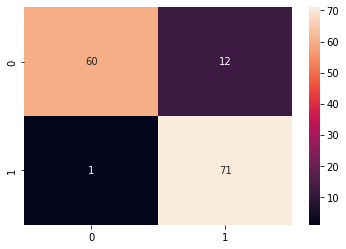

In [26]:
i = 3
y_p = []
pred = eegnet.predict_on_batch(data_array[i])
pred = pred.reshape(pred.shape[0])
for l in pred:
    if l>0.5:
        y_p.append(1)
    else:
        y_p.append(0)
y_t = label_array[i].reshape(label_array[i].shape)
print(classification_report(y_t, y_p))
cf_matrix = confusion_matrix(y_t, y_p)
sns.heatmap(cf_matrix, annot=True)

In [30]:
def find_accuracy(model,x,y):
    accuracy = []
    for i in range(len(x)):
        y_p = []
        pred = model.predict_on_batch(x[i])
        pred = pred.reshape(pred.shape[0])
        for l in pred:
            if l>0.5:
                y_p.append(1)
            else:
                y_p.append(0)
        y_t = y[i].reshape(y[i].shape)
        acc = accuracy_score(y_t, y_p)
        accuracy.append(acc)
    accuracy = np.array(accuracy)
    return accuracy

In [31]:
accuracy = find_accuracy(eegnet,data_array,label_array)

In [32]:
accuracy

array([0.88888889, 0.79861111, 0.97222222, 0.90972222, 0.90277778,
       0.88888889, 0.91666667, 0.95138889, 0.97222222])

In [33]:
accuracy.mean()

0.9112654320987653